In [1]:
import numpy as np
import torch.optim
from torch import nn
from tqdm import trange

In [2]:
from rand_mdp import RandMDP
from matplotlib import pyplot as plt

def perform_vi(states, rewards, dyn_mats, gamma=0.9, eps=1e-5):
    # Assume discrete actions and states
    q_values = np.zeros(dyn_mats.shape[:2])

    deltas = []
    while not deltas or deltas[-1] >= eps:
        old = q_values
        q_max = q_values.max(axis=0)
        q_values = rewards + gamma * dyn_mats @ q_max

        deltas.append(np.abs(old - q_values).max())

    return q_values, deltas

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


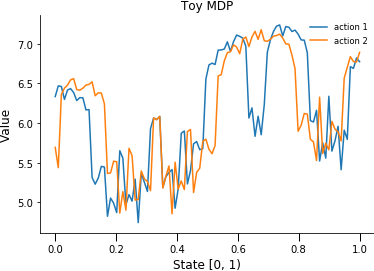

In [3]:
num_states = 100
mdp = RandMDP(seed=0, option='fixed')
states, rewards, dyn_mats = mdp.get_discrete_mdp(num_states=num_states)
gt_q_values, _ = perform_vi(states, rewards, dyn_mats)

plt.plot(states, gt_q_values[0], label="action 1")
plt.plot(states, gt_q_values[1], label="action 2")
plt.title("Toy MDP")
plt.legend()
plt.xlabel('State [0, 1)')
plt.ylabel('Value')
plt.show()

In [5]:
def supervised(states, values, lr=1e-4, gamma=0.9, n_epochs=100, device='cpu'):
    # Ge: need to initialize the Q function at zero
    Q = nn.Sequential(
        nn.Linear(1, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 2),
    ).to(device)

    optim = torch.optim.RMSprop(Q.parameters(), lr=lr)
    l2 = nn.functional.mse_loss

    states = torch.FloatTensor(states).unsqueeze(-1).to(device)
    values = torch.FloatTensor(values).to(device)

    losses = []

    for epoch in trange(n_epochs + 1):
        values_bar = Q(states)
        loss = l2(values_bar, values.T)
        losses.append(loss.detach())

        optim.zero_grad()
        loss.backward()
        optim.step()

    q_values = values_bar.T.detach().cpu().numpy()
    return q_values, losses

In [28]:
def supervised_residual(states, values, lr=1e-4, gamma=0.9, n_epochs=100, num_residual=5, device='cpu'):
    # Ge: need to initialize the Q function at zero
    Q = nn.Sequential(
        nn.Linear(1 + 2, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 2),
    ).to(device)

    optim = torch.optim.RMSprop(Q.parameters(), lr=lr)
    l2 = nn.functional.mse_loss

    states = torch.FloatTensor(states).unsqueeze(-1).to(device)
    values = torch.FloatTensor(values).to(device)

    losses = []

    for epoch in trange(n_epochs + 1):
        values_preds = (0*values).T
        loss = 0
        
        for i in range(num_residual):
            values_bar = Q(torch.cat([states, values_preds], dim=-1))
            loss += l2(values_bar, values.T - values_preds)
            values_preds += values_bar.detach() 
        
        losses.append(loss.detach())

        optim.zero_grad()
        loss.backward()
        optim.step()

    q_values = values_preds.T.detach().cpu().numpy()
    return q_values, losses

In [7]:
class FF(nn.Module):
    def __init__(self, in_features, out_features, scale=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.linear = nn.Linear(in_features, self.out_features)
        self.linear.requires_grad = False
        nn.init.normal_(self.linear.weight, 0, scale / self.in_features)
        nn.init.normal_(self.linear.bias, 0, 1)

    def forward(self, x, **_):
        x = np.pi * self.linear(x)
        return torch.sin(x)


def supervised_ff(states, values, lr=1e-4, gamma=0.9, n_epochs=100, B_scale=1, device='cpu'):
    # Ge: need to initialize the Q function at zero
    Q = nn.Sequential(
        FF(1, 400, scale=B_scale),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 400),
        nn.ReLU(),
        nn.Linear(400, 2),
    ).to(device)

    optim = torch.optim.RMSprop(Q.parameters(), lr=lr)
    l2 = nn.functional.mse_loss

    states = torch.FloatTensor(states).unsqueeze(-1).to(device)
    values = torch.FloatTensor(values).to(device)

    losses = []

    for epoch in trange(n_epochs + 1):
        values_bar = Q(states)
        loss = l2(values_bar, values.T)
        losses.append(loss.detach())

        optim.zero_grad()
        loss.backward()
        optim.step()

    q_values = values_bar.T.detach().cpu().numpy()
    return q_values, losses

100%|██████████| 401/401 [00:00<00:00, 445.37it/s]


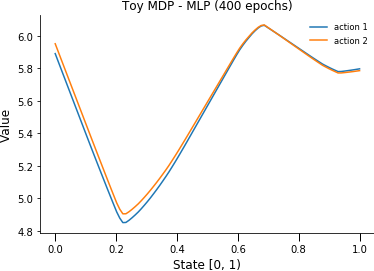

100%|██████████| 1001/1001 [00:02<00:00, 463.11it/s]


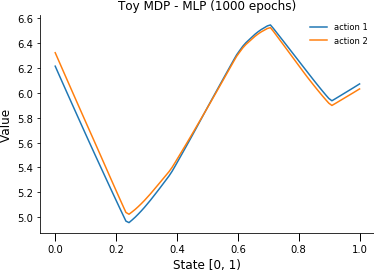

100%|██████████| 5001/5001 [00:12<00:00, 387.25it/s]


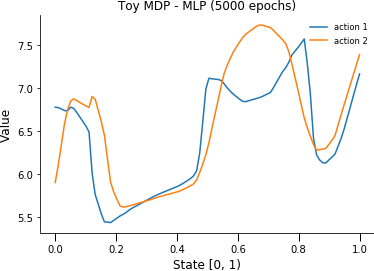

100%|██████████| 10001/10001 [00:23<00:00, 421.95it/s]


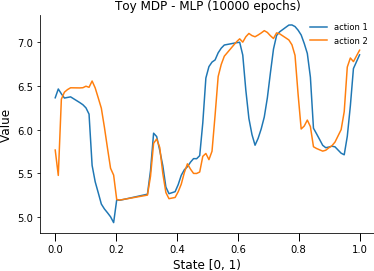

100%|██████████| 20001/20001 [00:43<00:00, 459.68it/s]


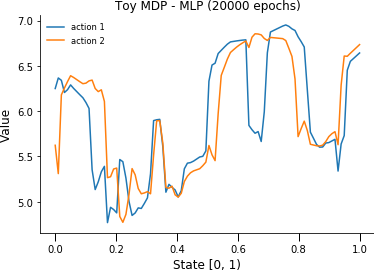

<Figure size 432x288 with 0 Axes>

In [26]:
for epoch in [400, 1000, 5000, 10000, 20000]:
    q_values, losses = supervised(states, gt_q_values, n_epochs=epoch, device='cuda')
    plt.plot(states, q_values[0], label="action 1")
    plt.plot(states, q_values[1], label="action 2")
    plt.title(f"Toy MDP - MLP ({epoch} epochs)")
    plt.legend()
    plt.xlabel('State [0, 1)')
    plt.ylabel('Value')
    plt.show()
    plt.clf()

100%|██████████| 401/401 [00:01<00:00, 379.29it/s]


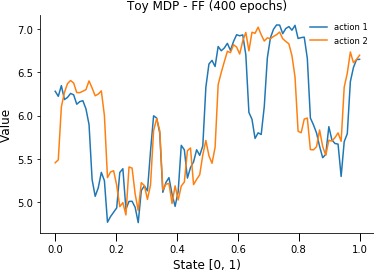

<Figure size 432x288 with 0 Axes>

In [8]:
q_values, losses = supervised_ff(states, gt_q_values, n_epochs=400, B_scale=10, device='cuda')
plt.plot(states, q_values[0], label="action 1")
plt.plot(states, q_values[1], label="action 2")
plt.title(f"Toy MDP - FF (400 epochs)")
plt.legend()
plt.xlabel('State [0, 1)')
plt.ylabel('Value')
plt.show()
plt.clf()

100%|██████████| 401/401 [00:01<00:00, 298.63it/s]


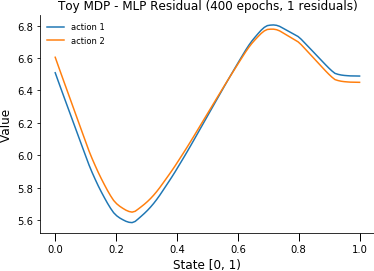

100%|██████████| 401/401 [00:00<00:00, 417.38it/s]


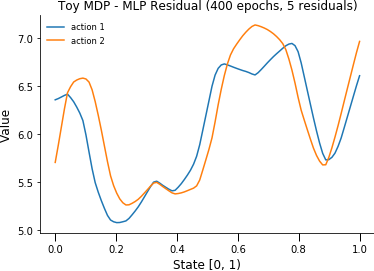

100%|██████████| 401/401 [00:00<00:00, 479.11it/s]


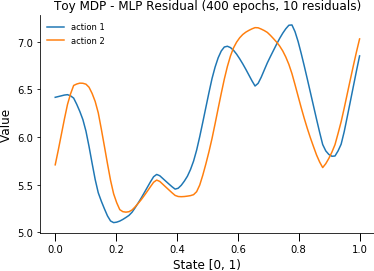

100%|██████████| 401/401 [00:01<00:00, 388.81it/s]


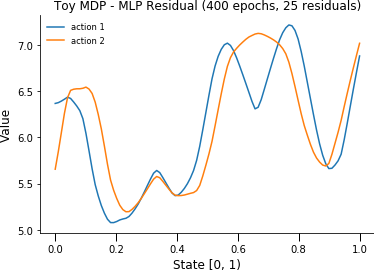

100%|██████████| 401/401 [00:01<00:00, 380.61it/s]


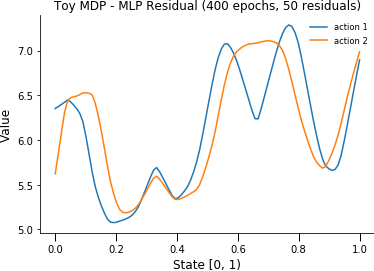

<Figure size 432x288 with 0 Axes>

In [36]:
# Residual method
from copy import deepcopy

for residual_num in [1, 5, 10, 25, 50]:
    q_values_list = []

    for i in range(residual_num):
        target_q_values = deepcopy(gt_q_values)
        if i > 0:
            for j in range(i):
                target_q_values -= q_values_list[j]
        
        this_q_values, _ = supervised(states, target_q_values, n_epochs=400, device='cuda')
        q_values_list.append(this_q_values)
    
    q_values = sum(q_values_list)

    plt.plot(states, q_values[0], label="action 1")
    plt.plot(states, q_values[1], label="action 2")
    plt.title(f"Toy MDP - MLP Residual (400 epochs, {residual_num} residuals)")
    plt.legend()
    plt.xlabel('State [0, 1)')
    plt.ylabel('Value')
    plt.show()
    plt.clf()

100%|██████████| 401/401 [00:04<00:00, 93.94it/s] 


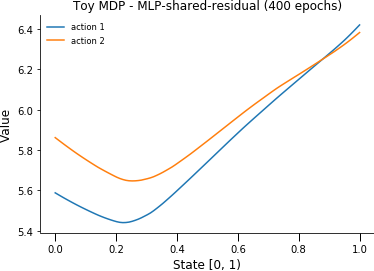

<Figure size 432x288 with 0 Axes>

In [30]:
q_values, losses = supervised_residual(states, gt_q_values, n_epochs=400, num_residual=10, device='cuda')
plt.plot(states, q_values[0], label="action 1")
plt.plot(states, q_values[1], label="action 2")
plt.title(f"Toy MDP - MLP-shared-residual (400 epochs)")
plt.legend()
plt.xlabel('State [0, 1)')
plt.ylabel('Value')
plt.show()
plt.clf()